In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [23]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    #function which given the current state (observation) gives the policy (probabilities of each action)
    def policy_fn(observation):
        best_action = np.argmax(Q[observation])
        probs = [epsilon/nA for i in range(nA)]
        probs[best_action] += 1.0-epsilon
        return probs

    return policy_fn

In [31]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    #for each episode
    for episode_num in range(num_episodes):
        episode = []
        #resets teh environment and produces a new state
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            #choose one action based on the probabilities p
            action = np.random.choice(np.arange(len(probs)), p = probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
    
        #Different from MC prediction because we are finding q so we need state action pairs
        sapairs = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sapairs:
            #find the first occurence of the state and action
            first = next(i for i,x in enumerate(episode) if x[0] == state and x[1 == action]) #the statement inside next gives a list of indices which have state as the selected state and next                gives the first element
            #sum the rewards after this point
            #just doing incremental mean. Not using the notes equation
            G = sum([x[2] * (discount_factor**i) for i,x in enumerate(episode[first:])])
            returns_sum[(state, action)] += G
            returns_count[(state,action)] += 1.0
            Q[state][action] = returns_sum[(state, action)]/returns_count[(state,action)]
            # Below is the equation for incremental mean mentioned in the notes
            #both give the same results
            #Q[state][action] += (1/returns_count[(state,action)]) * (G - Q[state][action]) 
    
    return Q, policy

In [32]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


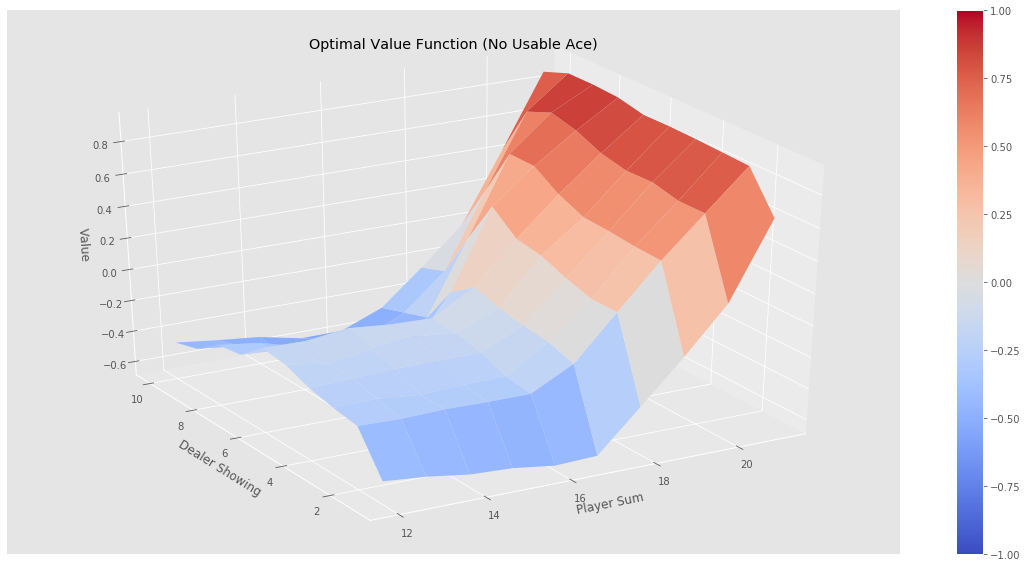

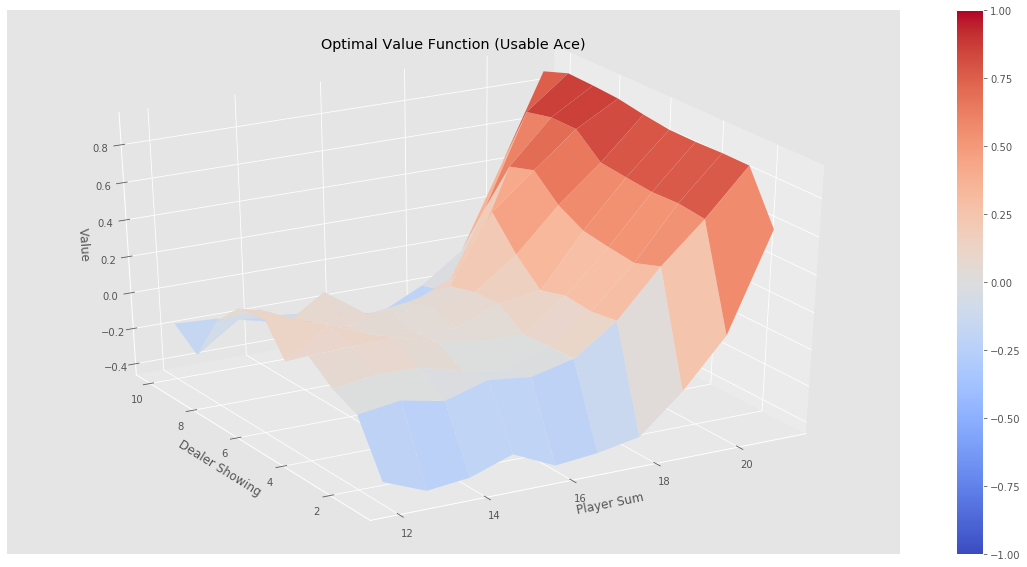

In [33]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")